<a href="https://colab.research.google.com/github/Sarah0711/CUDA-Vision-Lab/blob/main/Cifar10_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries Imports

In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random
import torchvision
import numpy as np 
import matplotlib.pyplot as plt 
from math import log, exp


In [ ]:
if torch.cuda.is_available():
    avDev = torch.device("cuda")
else:
    avDev = torch.device("cpu")


In [ ]:
seed = 1
torch.manual_seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True



In [ ]:
def show_images(img,labels):
    img = img / 2 + 0.5     # unnormalize
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [ ]:
'''
STEP 1: LOADING DATASET
'''

transform = transforms.Compose([
        # transforms.Resize(256),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
test_transform = transforms.Compose([
        # transforms.Resize(256),
        # transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = dsets.CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset = dsets.CIFAR10('./data', train=False, download=True, transform=test_transform)


0it [00:00, ?it/s]

 99%|█████████▉| 169140224/170498071 [00:12<00:00, 17254952.77it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
batch_size = 64
n_iters = 500000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

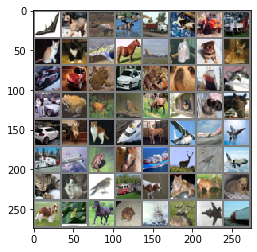

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           )
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          )

dataiter = train_loader.__iter__()
images, labels = dataiter.next()

show_images(torchvision.utils.make_grid(images),labels)

In [ ]:
input_dim = [int(exp(sum(map(log, images[0].shape))))]
output_dim = [len(train_dataset.classes)]
hidden_dim = [2048,1000,500,200]
model_arch = input_dim + hidden_dim + output_dim
print(model_arch)

[3072, 2048, 1000, 500, 200, 10]


In [ ]:
'''
STEP 3: CREATE MODEL CLASS
'''
class LogisticRegressionModel(nn.ModuleList):
    def __init__(self, model_arch):
        super(LogisticRegressionModel, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(model_arch[i], model_arch[i+1]) for i in range(len(model_arch)-1)])

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(0.5)
        self.sig = nn.Sigmoid()

     
    def forward(self, x):
        out = x
        for i in range(len(self.linears)-1):
            out = (self.sig(self.linears[i](out)))
        out = self.softmax(self.linears[-1](out))
        return out

# class LogisticRegressionModel(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(LogisticRegressionModel, self).__init__()
#         self.linear1 = nn.Linear(input_dim, 300)
#         self.linear2 = nn.Linear(300, output_dim)
#         self.relu = nn.ReLU()
     
#     def forward(self, x):
#         out = self.relu(self.linear1(x))
#         out = self.linear2(out)
#         return out

In [ ]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''

# model = LogisticRegressionModel(input_dim[0], output_dim[0])

model = LogisticRegressionModel(model_arch)
model.to(avDev)


LogisticRegressionModel(
  (linears): ModuleList(
    (0): Linear(in_features=3072, out_features=2048, bias=True)
    (1): Linear(in_features=2048, out_features=1000, bias=True)
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): Linear(in_features=500, out_features=200, bias=True)
    (4): Linear(in_features=200, out_features=10, bias=True)
  )
  (relu): ReLU()
  (softmax): Softmax(dim=None)
  (dropout): Dropout(p=0.5, inplace=False)
  (sig): Sigmoid()
)

In [ ]:
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss().to(avDev)


In [ ]:
'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.001
 
optimizer = torch.optim.Adam(list(model.parameters()), lr=learning_rate)

In [ ]:
def plot_learning_curve(loss_errors):
  plt.plot(np.array(loss_errors))

In [ ]:
n_classes = 10
print(n_classes)
conf_matrix = torch.zeros(n_classes, n_classes)

10


In [ ]:
def confusion_matrix(preds, labels):
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1



In [ ]:

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
losses =[]
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, input_dim[0]).to(avDev)
        labels = labels.to(avDev)
         
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)#
        losses.append(loss)
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
         
        iter += 1

    # Calculate Accuracy         
    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in test_loader:
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.view(-1, input_dim[0]).to(avDev)
          
        # Forward pass only to get logits/output
        outputs = model(images)
          
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        
        # Total number of labels
        total += labels.size(0)
          
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        correct += (predicted.cpu() == labels.cpu()).sum().float()
        #confusion_matrix(predicted.cpu(),labels.cpu())
    accuracy = 100. * correct / total
     
    # Print Loss
    print('Epoch: {}. Iteration: {}. Loss: {}. Accuracy: {}'.format(epoch, iter, loss.item(), accuracy))     

    #Epoch: 0. Iteration: 782. Loss: 1.785505771636963. Accuracy: 24.299999237060547
#Epoch: 1. Iteration: 1564. Loss: 1.590320110321045. Accuracy: 26.610000610351562
#Epoch: 2. Iteration: 2346. Loss: 1.5820738077163696. Accuracy: 23.06999969482422

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
170500096it [00:30, 17254952.77it/s]                               

Epoch: 0. Iteration: 782. Loss: 2.2097275257110596. Accuracy: 29.5
Epoch: 1. Iteration: 1564. Loss: 2.079061508178711. Accuracy: 33.04999923706055
Epoch: 2. Iteration: 2346. Loss: 2.2081127166748047. Accuracy: 35.869998931884766
Epoch: 3. Iteration: 3128. Loss: 2.1243724822998047. Accuracy: 35.68000030517578
Epoch: 4. Iteration: 3910. Loss: 2.0207324028015137. Accuracy: 38.5
Epoch: 5. Iteration: 4692. Loss: 1.945926308631897. Accuracy: 39.81999969482422
Epoch: 6. Iteration: 5474. Loss: 2.082662343978882. Accuracy: 40.45000076293945
Epoch: 7. Iteration: 6256. Loss: 2.1094167232513428. Accuracy: 40.400001525878906
Epoch: 8. Iteration: 7038. Loss: 2.010115385055542. Accuracy: 41.47999954223633
Epoch: 9. Iteration: 7820. Loss: 2.1678693294525146. Accuracy: 41.290000915527344
Epoch: 10. Iteration: 8602. Loss: 1.9463378190994263. Accuracy: 42.22999954223633
Epoch: 11. Iteration: 9384. Loss: 1.8912255764007568. Accuracy: 42.369998931884766
Epoch: 12. Iteration: 10166. Loss: 2.069321870803833.

In [ ]:
plot_learning_curve(losses)